# Generating Ensembles using GerryChain

Race and Redistricting Expert Project (RREP)

May 22, 2025



### Load packages and data



In [1]:
## run once to install necessary packages
# !pip install maup numpy
# !pip install gerrychain networkx gerrytools matplotlib gurobipy
# !pip install geopandas
# !pip install fiona==1.9.6

In [2]:
# Google Collab error: if imports fail, Restart the notebook and try again
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings; warnings.filterwarnings('ignore')

### Load data

In [3]:
import os
import requests

# Base URL where the shapefile is hosted
base_url = 'https://raw.githubusercontent.com/kkakey/rrep/main/Presentation-Ensembles/output-data/'

# List of all files related to the shapefile
shapefile_components = [
    'al_jefferson-2020_precincts.shp',
    'al_jefferson-2020_precincts.shx',
    'al_jefferson-2020_precincts.dbf',
    'al_jefferson-2020_precincts.prj', 
    'al_jefferson-2020_precincts.cpg'
]

# Download each file
os.makedirs('./precinct_shp/', exist_ok=True)  # Create directory if it doesn't exist
for file_name in shapefile_components:
    file_url = base_url + file_name
    local_file_path = os.path.join('./precinct_shp/', file_name)
    
    # Download and save each file
    response = requests.get(file_url)
    
    if response.status_code == 200:
        with open(local_file_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded: {file_name}")
    else:
        print(f"Failed to download: {file_name}")

# Load in shapefile
precincts = gpd.read_file('precinct_shp/al_jefferson-2020_precincts.shp')
precincts["geometry"] = precincts.buffer(0) #corrects small topological issues

Downloaded: al_jefferson-2020_precincts.shp
Downloaded: al_jefferson-2020_precincts.shx
Downloaded: al_jefferson-2020_precincts.dbf
Downloaded: al_jefferson-2020_precincts.prj
Downloaded: al_jefferson-2020_precincts.cpg


In [4]:
precincts.columns

Index(['GEOI', 'G20PRER', 'G20PRED', 'G20USSR', 'G20USSD', 'G20USSO',
       'G20PSCR', 'G20PSCD', 'G20PSCO', 'G20PREDO', 'G20PRE_TOT', 'G20USS_TOT',
       'G20PSC_TOT', 'prop_PRER', 'prop_PRED', 'prop_USSR', 'prop_USSD',
       'prop_PSCR', 'prop_PSCD', 'P0010001', 'P0040001', 'P0040002',
       'P0040005', 'P0040006', 'P0040007', 'P0040008', 'P0040009', 'P0040010',
       'P0040011', 'geometry'],
      dtype='object')

Text(0.5, 1.0, '% Voted Trump')

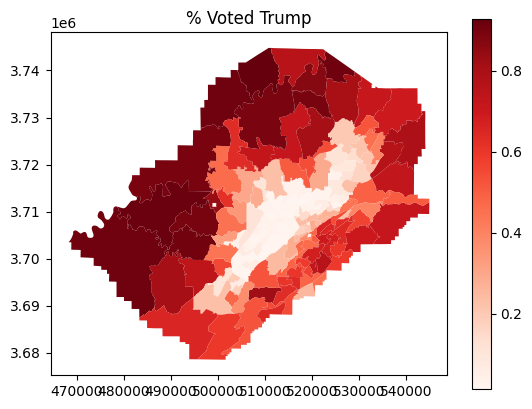

In [5]:
precincts.plot(column='prop_PRER', cmap='Reds', legend=True)
plt.title('% Voted Trump')

Text(0.5, 1.0, '% BVAP')

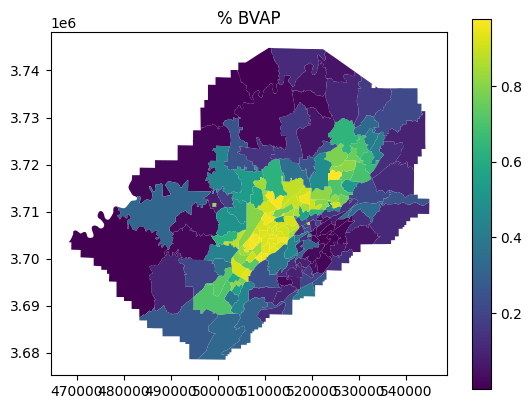

In [6]:
precincts['prop_BVAP'] = precincts['P0040006'] / precincts['P0040001']
precincts.plot(column='prop_BVAP', legend=True)
plt.title('% BVAP')

### MCMC Prep

In [55]:
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    GeographicPartition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import polsby_popper, efficiency_gap, mean_median
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from gerrytools.scoring import gingles_districts, demographic_shares, reock
import json
from statistics import mean
from functools import partial
import random
random.seed(99)

In [56]:
state_abbr = "AL"
num_districts = 5
unique_label = "GEOID"
tot_pop = "P0010001"

In [57]:
# create graph
graph = Graph.from_geodataframe(precincts)
graph.add_data(precincts,list(precincts))

/Users/kristenakey/.local/share/virtualenvs/Presentation-Ensembles-DOpX2fvx/lib/python3.11/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(9, 10), (11, 131), (128, 170), (119, 170), (167, 168), (75, 118)}
  warnings.warn(


In [58]:
# population check
pop = 0
for node in graph:
    pop = pop + int(graph.nodes[node][tot_pop])
pop

674721

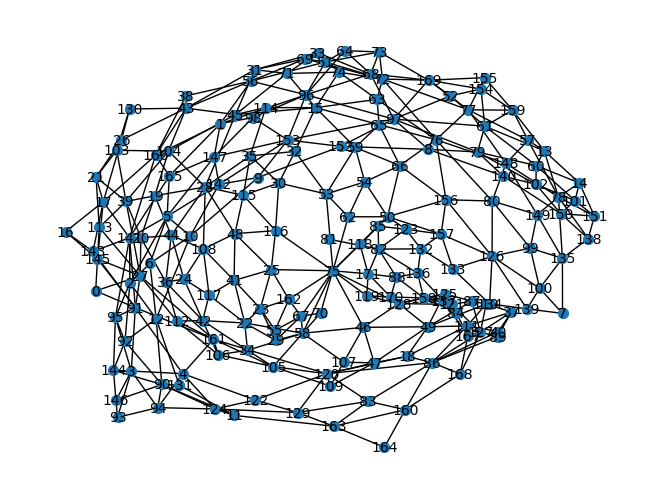

In [59]:
nx.draw(graph, with_labels=True, node_size=50, font_size=10)


### 1. Neutral Ensemble

#### Collect a representative sample of possible plans for ensemble analysis

See: https://gerrychain.readthedocs.io/en/latest/user/recom/

In [60]:
# define what gets tracked at each step
updater = {
    "population": updaters.Tally(tot_pop, alias="population"),
    "vap_pop": updaters.Tally("P0040001", alias="vap_pop"),
    "vap_black_pop": updaters.Tally("P0040006", alias="vap_black_pop"),
    "vap_hispanic_pop": updaters.Tally("P0040002", alias="vap_hispanic_pop"),
    "2020_pres" : Election("2020_pres", {"G20PRER":"G20PRER","G20PRED":"G20PRED"}, alias="2020_pres"),
    "2020_sen" : Election("2020_sen", {"G20USSR":"G20USSR","G20USSD":"G20USSD"}, alias="2020_sen"),
    "2020_pscr" : Election("2020_pres", {"G20PSCR":"G20PSCR","G20PSCD":"G20PSCD"}, alias="2020_pres"),
    "cut_edges": updaters.cut_edges
}

# if you have the current plan, you can set that as the initial partition
initial_partition = GeographicPartition.from_random_assignment(
    graph=graph,
    n_parts=num_districts,
    epsilon=0.025,
    pop_col=tot_pop,
    updaters=updater
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.05)

In [61]:
proposal = partial(
    recom,
    pop_col=tot_pop,
    pop_target=ideal_population,
    epsilon=0.025 # Initial population deviation allowable by the validator as a percentage of the ideal population. Defaults to 0.05
)

recom_chain = MarkovChain(
    proposal=proposal,
    # see https://gerrychain.readthedocs.io/en/latest/api/#module-gerrychain.constraints for possible constraints
    constraints=[contiguous, pop_constraint],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000
)

In [62]:
tot_pop = []
vap_black = []
vap_hispanic = []
prop_bvap = []
prop_hvap = []

polsby_popper_min = []
polsby_popper_avg = []

pres20 = []
sen20 = []
dem_seats_pres = []
dem_seats_sen = []
rep_seats_pres = []
rep_seats_sen = []
mean_medians_pres = []
egs_pres = []

t = 0
for part in recom_chain.with_progress_bar():
    tot_pop.append(part["population"])
    vap_black.append(part["vap_black_pop"])
    vap_hispanic.append(part["vap_hispanic_pop"])
    
    vap_black_prop = demographic_shares({"vap_pop": ["vap_black_pop"]})[0].apply(part)
    prop_bvap.append(vap_black_prop) 
    vap_hispanic_prop = demographic_shares({"vap_pop": ["vap_hispanic_pop"]})[0].apply(part)
    prop_hvap.append(vap_hispanic_prop) 
    
    polsby_popper_min.append(min(polsby_popper(part).values()))
    polsby_popper_avg.append(mean(polsby_popper(part).values()))
    
    pres20.append(sorted(part["2020_pres"].percents("G20PRED")))
    sen20.append(sorted(part["2020_sen"].percents("G20USSD")))
    
    dem_seats_pres.append(part["2020_pres"].wins("G20PRED"))
    rep_seats_pres.append(part["2020_pres"].wins("G20PRER"))
    dem_seats_sen.append(part["2020_sen"].wins("G20USSD"))
    dem_seats_sen.append(part["2020_sen"].wins("G20USSR"))
    
    mean_medians_pres.append(mean_median(part["2020_pres"]))
    egs_pres.append(efficiency_gap(part["2020_pres"]))
    
    t +=1
    if t%1000 ==0:
        print("chain",part,"step",t)

  0%|          | 0/10000 [00:00<?, ?it/s]

chain <GeographicPartition [5 parts]> step 1000
chain <GeographicPartition [5 parts]> step 2000
chain <GeographicPartition [5 parts]> step 3000
chain <GeographicPartition [5 parts]> step 4000
chain <GeographicPartition [5 parts]> step 5000
chain <GeographicPartition [5 parts]> step 6000
chain <GeographicPartition [5 parts]> step 7000
chain <GeographicPartition [5 parts]> step 8000
chain <GeographicPartition [5 parts]> step 9000
chain <GeographicPartition [5 parts]> step 10000


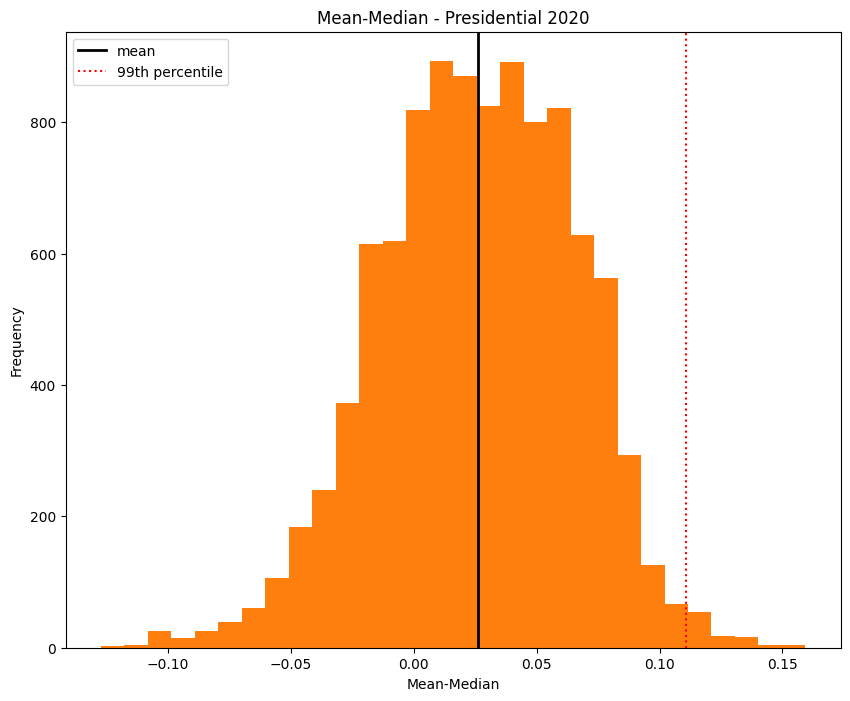

In [63]:
p99 = np.percentile(np.array(mean_medians_pres), 99) 

plt.figure(figsize=(10, 8))
plt.hist(mean_medians_pres, color="C1",bins=30)

# plt.axvline(0, color="black", lw=3, label="Zero")
plt.axvline(np.array(mean_medians_pres).mean(), label = 'mean',color="black", lw=2)
plt.axvline(p99, label = '99th percentile', linestyle = 'dotted' ,color = 'red')
# plt.axvline(mean_median(current_partition["2020_pres"]), label = 'Enacted plan', color = 'red')

plt.xlabel("Mean-Median")
plt.ylabel("Frequency")
plt.title("Mean-Median - Presidential 2020")
plt.legend()

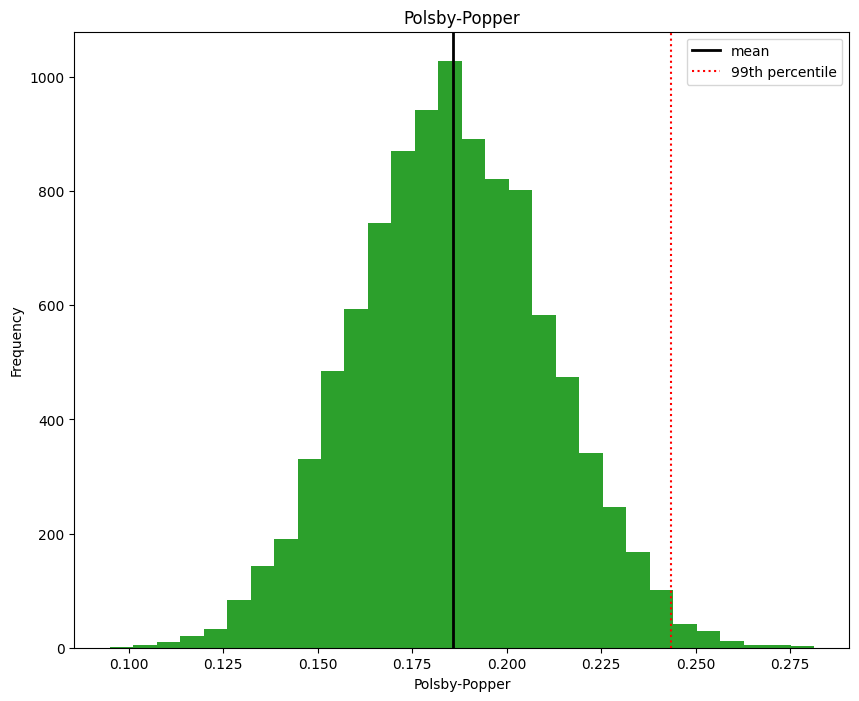

In [64]:
p99 = np.percentile(np.array(polsby_popper_avg), 99) 

plt.figure(figsize=(10, 8))
plt.hist(polsby_popper_avg, color="C2",bins=30)

# plt.axvline(0, color="black", lw=3, label="Zero")
plt.axvline(np.array(polsby_popper_avg).mean(), label = 'mean',color="black", lw=2)
plt.axvline(p99, label = '99th percentile', linestyle = 'dotted' ,color = 'red')

plt.xlabel("Polsby-Popper")
plt.ylabel("Frequency")
plt.title("Polsby-Popper")
plt.legend()

### 2. Optimization Ensemble

#### Search for plans with increased numbers of majority-minority districts

See: https://gerrychain.readthedocs.io/en/latest/user/optimizers/#using-gingleator

In [65]:
gingles_optimizer = Gingleator(
    proposal,
    constraints=[contiguous, pop_constraint],
    initial_state=initial_partition,
    minority_pop_col="vap_black_pop",
    total_pop_col="population",
    score_function=Gingleator.reward_partial_dist # several score functions available # num_opportunity_dists
)

 12%|█▏        | 1194/10000 [00:20<02:42, 54.09it/s]

1198 Gingles: 3 BVAP prop: [0.653014407340929, 0.5212452091432983, 0.5048058146070091, 0.24317088889990582, 0.09901081545381496]
1199 Gingles: 3 BVAP prop: [0.6174214825325, 0.5400373860298325, 0.5212452091432983, 0.24317088889990582, 0.09901081545381496]


 13%|█▎        | 1304/10000 [00:23<03:31, 41.04it/s]

1296 Gingles: 3 BVAP prop: [0.659928126451931, 0.520394020854456, 0.5174609337086286, 0.2402908351738561, 0.08768768216548212]


 13%|█▎        | 1340/10000 [00:24<03:38, 39.63it/s]

1336 Gingles: 3 BVAP prop: [0.6495042351531976, 0.5342726687022046, 0.5140870873187288, 0.2402908351738561, 0.08768768216548212]


 14%|█▍        | 1382/10000 [00:25<03:11, 45.05it/s]

1382 Gingles: 3 BVAP prop: [0.5421626610412115, 0.5295827297789822, 0.5189395399021233, 0.34876101566123574, 0.08768768216548212]
1383 Gingles: 3 BVAP prop: [0.5459793338336316, 0.5295827297789822, 0.5156907119283357, 0.34876101566123574, 0.08768768216548212]


 14%|█▍        | 1387/10000 [00:26<05:36, 25.63it/s]

1384 Gingles: 3 BVAP prop: [0.5459793338336316, 0.5331792389378854, 0.5123451047519816, 0.34876101566123574, 0.08768768216548212]


 15%|█▍        | 1459/10000 [00:27<03:41, 38.49it/s]

1462 Gingles: 3 BVAP prop: [0.644914817711811, 0.533218670870957, 0.5205565622330088, 0.2402908351738561, 0.08768768216548212]
1463 Gingles: 3 BVAP prop: [0.6486051243478848, 0.5307974439444928, 0.5205565622330088, 0.2402908351738561, 0.08768768216548212]


 15%|█▍        | 1480/10000 [00:28<03:54, 36.33it/s]

1483 Gingles: 3 BVAP prop: [0.6437145469381335, 0.5407902461052156, 0.5091470343155822, 0.24252548018429504, 0.08768768216548212]
1484 Gingles: 3 BVAP prop: [0.642534157132555, 0.5410543567331331, 0.5091470343155822, 0.24252548018429504, 0.08768768216548212]


 15%|█▍        | 1497/10000 [00:29<02:45, 51.25it/s]

1497 Gingles: 3 BVAP prop: [0.6239600665557404, 0.5268235294117647, 0.5192487472889088, 0.24252548018429504, 0.09750790211692319]


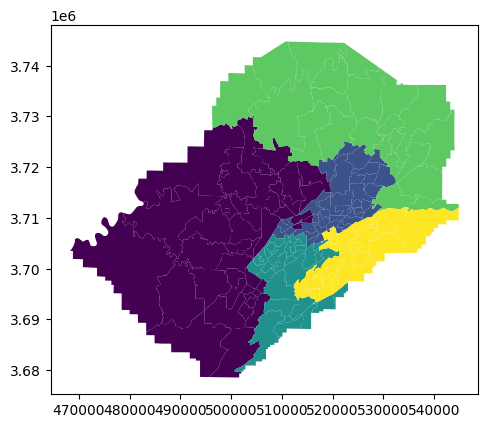

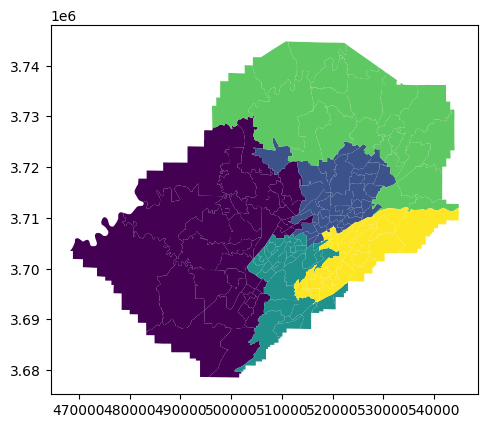

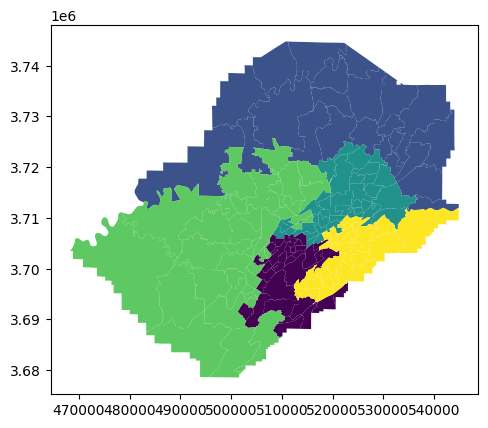

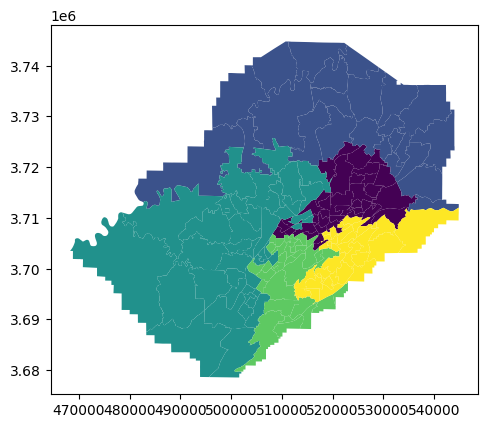

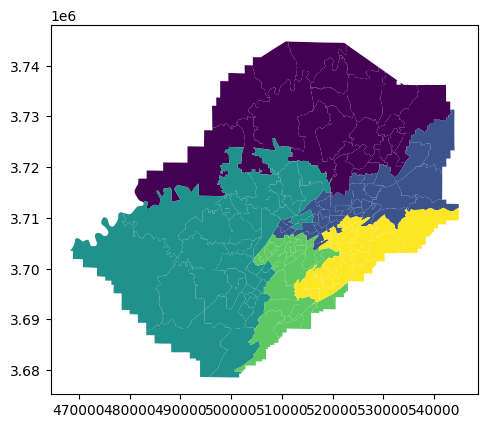

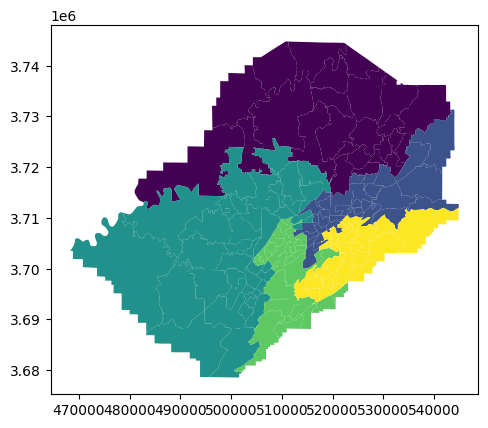

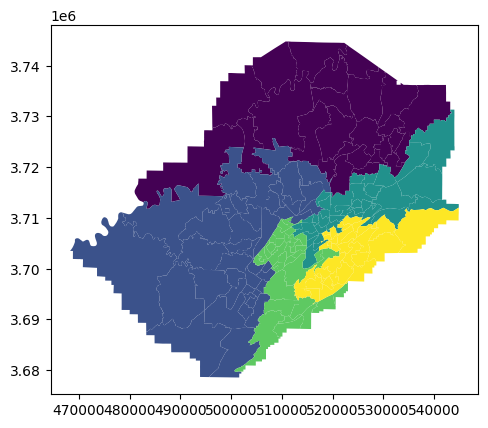

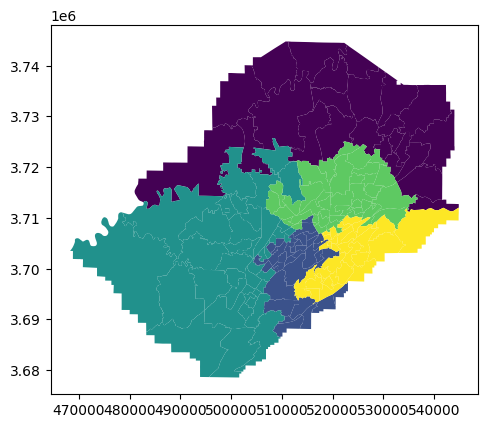

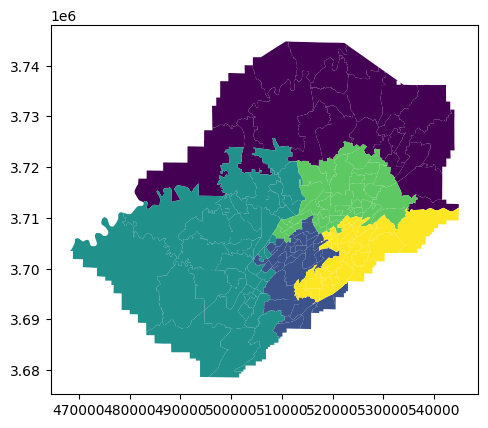

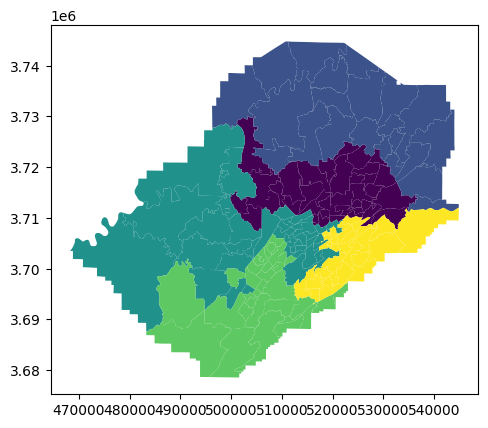

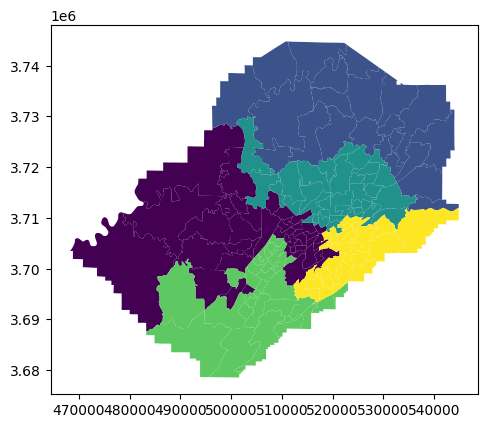

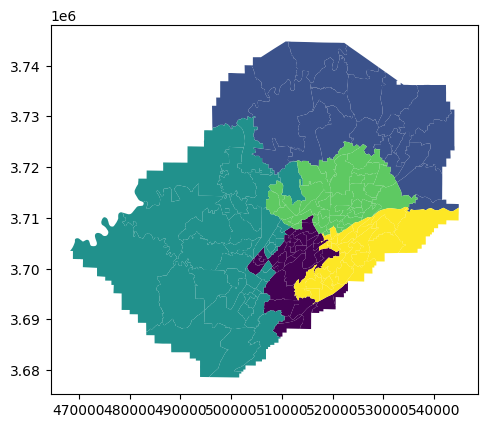

In [68]:
tot_pop = []
vap_black = []
vap_hispanic = []
prop_bvap = []
prop_hvap = []

polsby_popper_min = []
polsby_popper_avg = []

pres20 = []
sen20 = []
dem_seats_pres = []
dem_seats_sen = []
rep_seats_pres = []
rep_seats_sen = []
mean_medians_pres = []
egs_pres = []

gingles_scores = []

t = 0
print_ct = 0
for i, part in enumerate(gingles_optimizer.short_bursts(5, 2000, with_progress_bar=True)):
  
  tot_pop.append(part["population"])
  vap_black.append(part["vap_black_pop"])
  vap_hispanic.append(part["vap_hispanic_pop"])
  
  polsby_popper_min.append(min(polsby_popper(part).values()))
  polsby_popper_avg.append(mean(polsby_popper(part).values()))

  pres20.append(sorted(part["2020_pres"].percents("G20PRED")))
  sen20.append(sorted(part["2020_sen"].percents("G20USSD")))

  dem_seats_pres.append(part["2020_pres"].wins("G20PRED"))
  rep_seats_pres.append(part["2020_pres"].wins("G20PRER"))
  
  mean_medians_pres.append(mean_median(part["2020_pres"]))
  egs_pres.append(efficiency_gap(part["2020_pres"]))
  
  vap_black_prop = demographic_shares({"vap_pop": ["vap_black_pop"]})[0].apply(part)
  gd = gingles_districts({"vap_pop": ["vap_black_pop"]}, threshold=0.5)[0].apply(part)
  gingles_scores.append(gd)
  
  if gd >=3:
    print(t, 'Gingles:', gd, 'BVAP prop:', sorted(vap_black_prop.values(), reverse=True))
    part.plot()
    ### not necessary to include this break. I did to show only a few examples. If you want to see all, comment out next two lines
    if print_ct > 10:
      break
    print_ct += 1
    
  t +=1